In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("data_daily.csv")
print(df.shape)
df.head()

(365, 2)


,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


In [79]:
# Convert Date tp pandas datetime format to sum all the receipts for each month
df['# Date'] = pd.to_datetime(df['# Date'])
df['Month'] = df['# Date'].dt.month

In [80]:
# Sum all receipts by each month. January has 236736687 scaned receipts and so on
sum_month = df.groupby('Month')['Receipt_Count'].sum()
sum_month_df = sum_month.to_frame().reset_index()
sum_month_df

,Month,Receipt_Count
0,1,236736687
1,2,220033460
2,3,248608625
3,4,250644830
4,5,263151748
5,6,260656840
6,7,274776003
7,8,283943231
8,9,281146154
9,10,295965185


In [134]:
'''
    Normalize both colums so that they are on the same scale as neural Neeorks depend on gradients for optimization. Gradients tend to be sensitive to features with different scales.
    Using Min-Max scaling to normalize the values for both columns between 0 and 1
    Min-Max Scaling from scratch
    Formula: (X - X_min) / (X_max - X_min)
    Month_max is 24 because to predict values for the next 12 months, need to normalize the months to consider the 12 months in 2022
'''
Month_min = 1
Month_max = 24
Receipt_min = sum_month_df['Receipt_Count'].min()   # Get the min value of receipts
Receipt_max = sum_month_df['Receipt_Count'].max()   # Get the max value of receipts
sum_month_df['Normalized_receipts'] = (sum_month_df['Receipt_Count'] - Receipt_min) / (Receipt_max - Receipt_min)
sum_month_df['Normalized_month'] = (sum_month_df['Month'] - Month_min) / (Month_max - Month_min)
sum_month_df

,Month,Receipt_Count,Normalized_receipts,Normalized_month
0,1,236736687,0.185766,0.000000
1,2,220033460,0.000000,0.043478
2,3,248608625,0.317801,0.086957
3,4,250644830,0.340447,0.130435
4,5,263151748,0.479544,0.173913
5,6,260656840,0.451796,0.217391
6,7,274776003,0.608824,0.260870
7,8,283943231,0.710778,0.304348
8,9,281146154,0.679670,0.347826
9,10,295965185,0.844481,0.391304


Text(0, 0.5, 'Normalized Recepit Count')

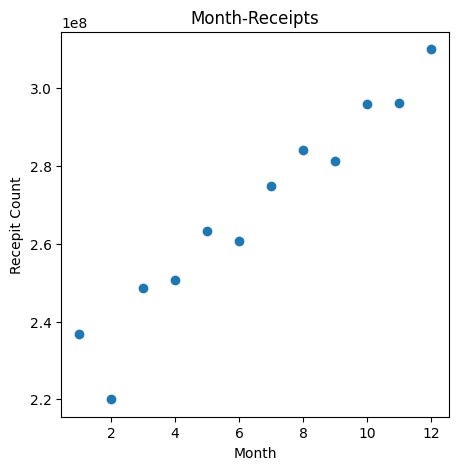

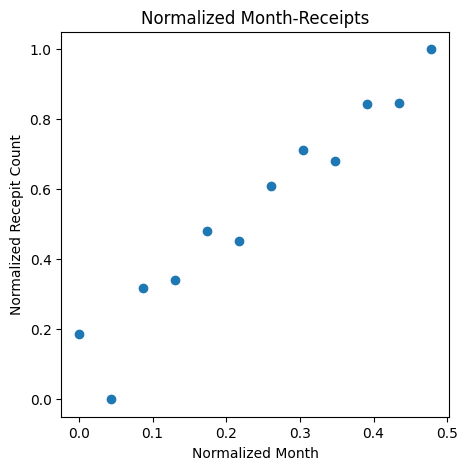

In [135]:
# These two plots show is that the Normalized and the "Un-Normalized" features have the same trend
plt.figure(figsize=(5, 5))
plt.scatter(x=sum_month_df['Month'], y=sum_month_df['Receipt_Count'])
plt.title('Month-Receipts')
plt.xlabel('Month')
plt.ylabel("Recepit Count")

plt.figure(figsize=(5, 5))
plt.scatter(x=sum_month_df['Normalized_month'], y=sum_month_df['Normalized_receipts'])
plt.title('Normalized Month-Receipts')
plt.xlabel('Normalized Month')
plt.ylabel("Normalized Recepit Count")

In [116]:
# Split data into X and y
X = sum_month_df[['Normalized_month']].values
y = sum_month_df[['Normalized_receipts']].values

In [139]:
# Split data ratio: 9 rows for training and 2 rows for testing
X_train = X[: int(0.75 * len(X))]
y_train = y[: int(0.75 * len(y))]
X_test = X[int(0.75 * len(X)): ]
y_test = y[int(0.75 * len(y)): ]

In [141]:
# Convert data into tensors so the model can process them
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)
X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([9, 1]),
 torch.Size([9, 1]),
 torch.Size([3, 1]),
 torch.Size([3, 1]))

In [88]:
'''
    Define model architecture
    model has 2 layers
        1st layer takes in 1 value for input and outputs 8 values
        2nd layer takes in 8 values for input and outputs 1 value (the prediction)
        using the ReLu() activation function
'''
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(in_features=1, out_features=8)
        self.layer2 = nn.Linear(in_features=8, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [105]:
torch.manual_seed(42)
model = NN() # Initialize model
loss = nn.MSELoss() # Mean Squared Error for the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Adam optimizer and learning rate of 0.01

In [106]:
# Model Training
epochs = 150 # Train for 15 epochs
losses = []
for i in range(epochs):
    y_pred = model.forward(X_train_tensor)
    loss_vals = loss(y_pred, y_train_tensor)
    losses.append(loss_vals.item())
    if i % 20 == 0:
        print(f'Epoch: {i} Loss: {loss_vals}')
        
    optimizer.zero_grad()
    loss_vals.backward()
    optimizer.step()
            

Epoch: 0 Loss: 0.5242113471031189
Epoch: 20 Loss: 0.03778054937720299
Epoch: 40 Loss: 0.017658157274127007
Epoch: 60 Loss: 0.012577683664858341
Epoch: 80 Loss: 0.009282935410737991
Epoch: 100 Loss: 0.007129042409360409
Epoch: 120 Loss: 0.0060393731109797955
Epoch: 140 Loss: 0.005691321101039648


Text(0, 0.5, 'Loss')

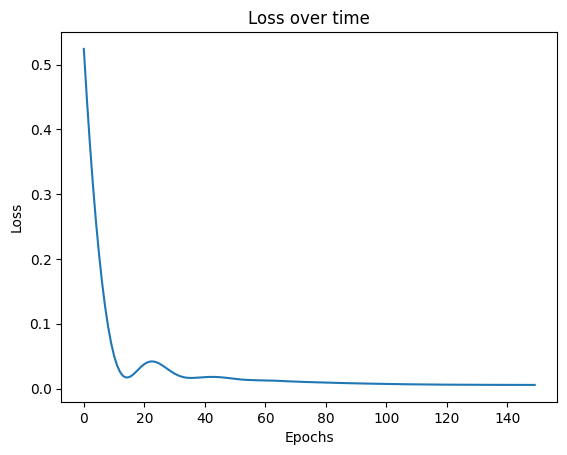

In [151]:
plt.plot(range(epochs), losses)
plt.title('Loss over time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [147]:
# Testing
with torch.no_grad():
    y_pred = model.forward(X_test_tensor)
    loss_val = loss(y_pred, y_test_tensor)
    print(f'Overall test loss: {loss_val}')

Overall test loss: 0.0013517257757484913


In [110]:
# Save models weights to run inference elsewhere
torch.save(model.state_dict(), 'NN_test.pth')